# カメラのキャリブレーション

### カメラ情報
- Google Pixel3 の video モード、倍率1
- 動画で撮るとぼやけてるフレームが多かったので、100枚から10枚選別して使う

In [1]:
!rm -r calib
!mkdir -p calib

In [2]:
from skvideo.io import vread
import matplotlib.pyplot as plt
import cv2

### キャリブレーション用画像の取得
- いったん映像から3フレームおきに画像をcalib/に保存
- その中からボケていないものを手作業でcalib_good/に入れた

303


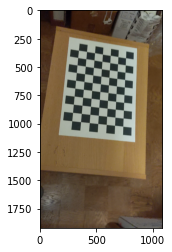

In [3]:
vid = vread("src/calib.mp4")
print(len(vid))

for i, frame in enumerate(vid[:300:3]):
    cv2.imwrite("calib/calib/calib{:02}.jpg".format(i), frame[..., ::-1])

plt.imshow(frame); plt.show()

### calib_goodの中の画像を使ってキャリブレーション

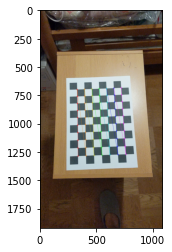

In [4]:
import numpy as np
import cv2
import glob

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(10-1,7-1,0)
objp = np.zeros((7*10,3), np.float32)
objp[:,:2] = np.mgrid[0:10,0:7].T.reshape(-1,2)

objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = sorted(glob.glob('calib/calib_good/calib*.jpg'))

for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (10,7),None)

    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
        img = cv2.drawChessboardCorners(img, (10,7), corners2,ret)
        if i==0: plt.imshow(img[...,::-1]); plt.show()

In [5]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [6]:
print(ret)

0.346445516441367


In [7]:
print(mtx)

[[1.83882882e+03 0.00000000e+00 5.20791172e+02]
 [0.00000000e+00 1.82803295e+03 9.76365659e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [8]:
print(dist)

[[ 2.97906356e-01 -4.84831541e-01  4.55397225e-03  8.49742572e-04
  -1.61521682e+00]]


### キャリブレーション結果の保存

In [9]:
np.save("camera/mtx.npy", mtx); np.save("camera/dist.npy", dist)